# 📊 Real Data Analysis: Option Pricing Model Comparison

This notebook calibrates and compares four stochastic volatility models using **real SPY option chain data**:

| Model | Description |
|-------|-------------|
| **Heston** | Stochastic volatility with mean-reversion |
| **Merton** | Jump-diffusion model (constant volatility + jumps) |
| **Bates** | Heston + Merton (stochastic vol + price jumps) |
| **SVJJ** | Bates + volatility jumps (most complex) |

---

## 1. Data Loading & Preprocessing

We download real-time SPY option chain data from Yahoo Finance and prepare it for calibration.

In [1]:
# =============================================================================
# [MUST BE FIRST] Fix OpenMP Duplicate Library Error
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Now import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import torch
import sys
import gc

# Add parent directory to path for imports
sys.path.append(os.path.abspath('..'))
from src.physics_engine import MarketSimulator

print("Libraries loaded successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries loaded successfully!
PyTorch version: 2.9.1+cu128
CUDA available: True


In [2]:
# 수정된 physics_engine을 반영하기 위해 모듈 리로드
import importlib
import src.physics_engine
importlib.reload(src.physics_engine)
from src.physics_engine import MarketSimulator

print("✅ Physics Engine Reloaded with Parameter Injection Support!")

✅ Physics Engine Reloaded with Parameter Injection Support!


In [3]:
# =============================================================================
# Download SPY Option Chain Data
# =============================================================================
ticker = "SPY"
print(f"[{ticker}] Downloading option chain data...")

spy = yf.Ticker(ticker)

# Get current price
try:
    current_price = spy.history(period="1d")['Close'].iloc[-1]
    print(f"✅ Current Price (S0): ${current_price:.2f}")
except Exception as e:
    current_price = 580.0
    print(f"⚠️ Failed to load price. Using fallback: ${current_price}")

# Select expiration date (30-75 days out for good liquidity)
expirations = spy.options
target_date = None
today = datetime.now()

for exp_date in expirations:
    exp_dt = datetime.strptime(exp_date, "%Y-%m-%d")
    days_to_expire = (exp_dt - today).days
    if 30 <= days_to_expire <= 75:
        target_date = exp_date
        print(f"✅ Selected Expiration: {target_date} ({days_to_expire} days)")
        break

if target_date is None:
    target_date = expirations[min(3, len(expirations)-1)]
    exp_dt = datetime.strptime(target_date, "%Y-%m-%d")
    days_to_expire = (exp_dt - today).days
    print(f"⚠️ Fallback Expiration: {target_date} ({days_to_expire} days)")

[SPY] Downloading option chain data...
✅ Current Price (S0): $690.31
✅ Selected Expiration: 2026-01-30 (31 days)


In [4]:
# =============================================================================
# Data Cleaning & Preprocessing
# =============================================================================
opt_chain = spy.option_chain(target_date)
calls = opt_chain.calls

print(f"Raw call options: {len(calls)}")

# Filter for liquidity
calls_clean = calls[(calls['volume'] > 5) | (calls['openInterest'] > 10)].copy()

# Extract relevant columns
market_data = calls_clean[['strike', 'impliedVolatility', 'lastPrice']].copy()
market_data = market_data.sort_values('strike')

# Remove outliers
market_data = market_data[
    (market_data['impliedVolatility'] > 0.01) & 
    (market_data['impliedVolatility'] < 1.0)
]

# Focus on near-the-money options (80% - 120% of spot)
market_data = market_data[
    (market_data['strike'] > current_price * 0.8) & 
    (market_data['strike'] < current_price * 1.2)
]

print(f"✅ Preprocessed: {len(market_data)} valid data points")
market_data.head(10)

Raw call options: 217
✅ Preprocessed: 42 valid data points


,strike,impliedVolatility,lastPrice
157,701.0,0.015635,5.79
158,702.0,0.015635,5.31
159,703.0,0.015635,4.93
160,704.0,0.015635,4.54
161,705.0,0.015635,4.20
162,706.0,0.015635,3.90
163,707.0,0.015635,3.61
164,708.0,0.015635,3.30
165,709.0,0.015635,3.02
166,710.0,0.015635,2.73


In [5]:
# =============================================================================
# Define Calibration Variables
# =============================================================================
calib_strikes = market_data['strike'].values
calib_ivs = market_data['impliedVolatility'].values

# Time to Maturity (in years)
expiry_date = datetime.strptime(target_date, "%Y-%m-%d")
T_val = max((expiry_date - today).days / 365.0, 0.01)

# Risk-free Rate & Time Step
r_val = 0.04  # ~4% (current Fed rate)
dt_val = 1/252  # Daily time step

print("=" * 50)
print("Calibration Parameters")
print("=" * 50)
print(f"  S0 (Spot Price):    ${current_price:.2f}")
print(f"  T (Time to Expiry): {T_val:.4f} years ({int(T_val*365)} days)")
print(f"  r (Risk-free Rate): {r_val:.2%}")
print(f"  dt (Time Step):     {dt_val:.6f}")
print(f"  # Strikes:          {len(calib_strikes)}")
print("=" * 50)

Calibration Parameters
  S0 (Spot Price):    $690.31
  T (Time to Expiry): 0.0849 years (31 days)
  r (Risk-free Rate): 4.00%
  dt (Time Step):     0.003968
  # Strikes:          42


---

## 2. Helper Functions

We define the **Black-Scholes pricing formula** and an **implied volatility solver** using Brent's method.

In [6]:
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call_price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes call option price.
    """
    if sigma <= 0 or T <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put_price(S, K, T, r, sigma):
    """
    Calculate Black-Scholes put option price (New).
    """
    if sigma <= 0 or T <= 0:
        return 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_vol_solver(market_price, S, K, T, r, sigma_low=0.001, sigma_high=5.0, option_type='call'):
    """
    Solve for implied volatility using Brent's method.
    Supports both 'call' (default) and 'put'.
    """
    if market_price <= 0 or T <= 0 or S <= 0 or K <= 0:
        return np.nan
    
    option_type = str(option_type).lower()
    
    # Check arbitrage bounds & Define Objective
    if option_type == 'call':
        intrinsic = max(S - K * np.exp(-r * T), 0)
        if market_price < intrinsic - 1e-4:
            return np.nan
        if market_price >= S:
            return np.nan
        def objective(sigma):
            return black_scholes_call_price(S, K, T, r, sigma) - market_price
            
    elif option_type == 'put':
        intrinsic = max(K * np.exp(-r * T) - S, 0)
        if market_price < intrinsic - 1e-4:
            return np.nan
        if market_price >= K * np.exp(-r * T):
            return np.nan
        def objective(sigma):
            return black_scholes_put_price(S, K, T, r, sigma) - market_price
            
    else:
        return np.nan
    
    try:
        f_low = objective(sigma_low)
        f_high = objective(sigma_high)
        if f_low * f_high > 0:
            return np.nan
        return brentq(objective, sigma_low, sigma_high, maxiter=100)
    except:
        return np.nan

print("✅ Helper functions defined (Updated with OTM Put support)!")

✅ Helper functions defined (Updated with OTM Put support)!


---

## 3. Calibration Loss Function

The loss function:
1. Unpacks model parameters
2. Runs Monte Carlo simulation using `MarketSimulator`
3. Calculates model-implied volatilities
4. Returns RMSE between model IVs and market IVs

In [7]:
def calibration_loss(params, model_name, market_strikes, market_ivs, S0, T, r, dt, num_paths, simulator):
    """
    GPU-accelerated RMSE calculation using MarketSimulator
    """
    try:
        # =====================================================
        # 1. Parameter Unpacking & Configuration
        # =====================================================
        params_dict = {}
        
        # 기본 공통 파라미터 (mu는 risk-free rate r로 고정)
        params_dict['mu'] = r
        
        if model_name == 'heston':
            kappa, theta, xi, rho = params
            params_dict.update({'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho})
            params_dict.update({'jump_lambda': 0, 'jump_mean': 0, 'jump_std': 0, 'vol_jump_mean': 0})
            val_type = 'heston'
            
        elif model_name == 'merton':
            sigma, jump_lambda, jump_mean, jump_std = params
            # Merton을 Heston의 특수한 경우로 표현 (kappa=Large, theta=sigma^2, xi=0)
            # 하지만 여기서는 Heston 시뮬레이터니까 xi=0에 가깝게 두고 theta를 맞춤
            params_dict.update({
                'kappa': 10.0, 'theta': sigma**2, 'xi': 0.001, 'rho': 0.0,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
            })
            val_type = 'bates' # Merton is effectively Bates with zero stoch vol
            
        elif model_name == 'bates':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std = params
            params_dict.update({
                'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': 0
            })
            val_type = 'bates'
            
        elif model_name == 'svjj':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean = params
            params_dict.update({
                'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho,
                'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 
                'vol_jump_mean': vol_jump_mean
            })
            val_type = 'svjj'
            if vol_jump_mean < 0: return 1e9

        # Safety Checks
        if params_dict.get('kappa', 1) < 0 or params_dict.get('theta', 1) < 0 or params_dict.get('xi', 1) < 0:
            return 1e9
        if abs(params_dict.get('rho', 0)) > 0.99:
            return 1e9

    except Exception as e:
        return 1e9

    # =====================================================
    # 2. GPU Monte Carlo Simulation
    # =====================================================
    try:
        # 시뮬레이터 인스턴스 재사용 (Dynamic Parameter Injection)
        S_paths, _ = simulator.simulate(
            S0=S0, 
            v0=params_dict.get('theta', 0.04), # 시작 분산을 장기 평균 분산으로 가정
            T=T, 
            dt=dt, 
            num_paths=num_paths, 
            model_type=val_type,
            override_params=params_dict
        )
        
        S_final = S_paths[:, -1] # (num_paths,)
        
        # NaNs check
        if torch.isnan(S_final).any() or torch.mean(S_final) < 1e-3:
            return 1e9
        
        # Martingale Correction (GPU)
        S_mean = torch.mean(S_final)
        S_corr = S_final * (S0 / S_mean)
        
        # =====================================================
        # 3. Payoff & RMSE Calculation
        # =====================================================
        market_strikes_gpu = torch.tensor(market_strikes, device=simulator.device).float()
        
        # Broadcasting: (num_paths, 1) - (num_strikes) -> (num_paths, num_strikes)
        payoffs = torch.maximum(S_corr.unsqueeze(1) - market_strikes_gpu, torch.tensor(0.0, device=simulator.device))
        
        # Discounted expected payoff
        model_prices = torch.mean(payoffs, dim=0) * torch.exp(torch.tensor(-r * T))
        model_prices = model_prices.cpu().numpy() # Move to CPU for IV solver
        
        error_sum = 0.0
        valid_count = 0
        
        for i, K in enumerate(market_strikes):
            m_price = model_prices[i]
            m_iv = implied_vol_solver(m_price, S0, K, T, r)
            target_iv = market_ivs[i]
            
            if np.isnan(m_iv) or m_iv < 0.001 or m_iv > 5.0:
                error_sum += 0.05 # Penalty
            else:
                error_sum += (m_iv - target_iv) ** 2
                valid_count += 1
        
        if valid_count < len(market_strikes) * 0.5:
            return 1e9
            
        return np.sqrt(error_sum / len(market_strikes))
        
    except Exception as e:
        return 1e9

---

## 4. Model Calibration

We use **Differential Evolution** (a global optimizer) to find the best parameters for each model.

In [8]:
from scipy.optimize import differential_evolution
import gc

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# =====================================================
# High-Precision GPU Configuration
# =====================================================
N_paths = 100000  # 300 -> 100,000 (약 300배 증가)
simulator = MarketSimulator(mu=r_val, kappa=1.0, theta=0.04, xi=0.5, rho=-0.7, device='cuda')

# Optimization settings (More aggressive)
base_opts = {
    'strategy': 'best1bin',
    'maxiter': 50,       # 8 -> 50 (충분한 수렴)
    'popsize': 15,       # 5 -> 15 (다양성 확보)
    'tol': 0.01,
    'mutation': (0.5, 1.0),
    'recombination': 0.7,
    'workers': 1,
    'disp': True         # 진행 상황 출력
}

# Updated Arguments: Pass 'simulator' instance at the end
calib_args = (calib_strikes, calib_ivs, current_price, T_val, r_val, dt_val, N_paths, simulator)

print("=" * 60)
print(f"Starting GPU-Accelerated Calibration")
print(f"  Paths:      {N_paths:,}")
print(f"  Iterations: {base_opts['maxiter']}")
print("=" * 60)

Starting GPU-Accelerated Calibration
  Paths:      100,000
  Iterations: 50


In [9]:
# =============================================================================
# 1. Heston Model
# =============================================================================
print("\n[1/4] 🔄 Calibrating Heston Model...")
print("     Parameters: kappa, theta, xi, rho")

bounds_heston = [
    (0.5, 3.0),   # kappa: mean-reversion speed (narrower)
    (0.02, 0.1),  # theta: long-term variance (narrower)
    (0.2, 1.0),   # xi: vol-of-vol (narrower)
    (-0.8, -0.2)  # rho: correlation (typically negative)
]

try:
    res_heston = differential_evolution(
        calibration_loss, bounds_heston, 
        args=('heston', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Heston RMSE: {res_heston.fun:.4f}")
    print(f"     Parameters: kappa={res_heston.x[0]:.3f}, theta={res_heston.x[1]:.4f}, xi={res_heston.x[2]:.3f}, rho={res_heston.x[3]:.3f}")
except Exception as e:
    print(f"     ❌ Heston Error: {e}")
    res_heston = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7], 'fun': 1e9})()

gc.collect()


[1/4] 🔄 Calibrating Heston Model...
     Parameters: kappa, theta, xi, rho
differential_evolution step 1: f(x)= 0.0694380304047697
differential_evolution step 2: f(x)= 0.0694380304047697
differential_evolution step 3: f(x)= 0.06794939331398114
differential_evolution step 4: f(x)= 0.06224205318087154
differential_evolution step 5: f(x)= 0.06224205318087154
differential_evolution step 6: f(x)= 0.06219706485065788
differential_evolution step 7: f(x)= 0.060765316485726605
differential_evolution step 8: f(x)= 0.060765316485726605
differential_evolution step 9: f(x)= 0.060765316485726605
differential_evolution step 10: f(x)= 0.05958773190920436
differential_evolution step 11: f(x)= 0.057433878429756884
differential_evolution step 12: f(x)= 0.0566055686084482
differential_evolution step 13: f(x)= 0.0566055686084482
differential_evolution step 14: f(x)= 0.0566055686084482
differential_evolution step 15: f(x)= 0.0566055686084482
differential_evolution step 16: f(x)= 0.0566055686084482
differen

910

In [10]:
# =============================================================================
# 2. Merton Model
# =============================================================================
print("\n[2/4] 🔄 Calibrating Merton Model...")
print("     Parameters: sigma, jump_lambda, jump_mean, jump_std")

bounds_merton = [
    (0.1, 0.4),   # sigma
    (0.5, 3.0),   # jump_lambda
    (-0.2, 0.0),  # jump_mean
    (0.05, 0.2)   # jump_std
]

try:
    res_merton = differential_evolution(
        calibration_loss, bounds_merton, 
        args=('merton', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Merton RMSE: {res_merton.fun:.4f}")
    print(f"     Parameters: sigma={res_merton.x[0]:.3f}, lambda={res_merton.x[1]:.3f}, mu_j={res_merton.x[2]:.3f}, sigma_j={res_merton.x[3]:.3f}")
except Exception as e:
    print(f"     ❌ Merton Error: {e}")
    res_merton = type('obj', (object,), {'x': [0.2, 1.0, -0.1, 0.1], 'fun': 1e9})()

gc.collect()


[2/4] 🔄 Calibrating Merton Model...
     Parameters: sigma, jump_lambda, jump_mean, jump_std
differential_evolution step 1: f(x)= 0.09066507183075179
differential_evolution step 2: f(x)= 0.07776918964664552
differential_evolution step 3: f(x)= 0.07762823222702131
differential_evolution step 4: f(x)= 0.07457350741911983
differential_evolution step 5: f(x)= 0.0689190874398159
differential_evolution step 6: f(x)= 0.0689190874398159
differential_evolution step 7: f(x)= 0.0689190874398159
differential_evolution step 8: f(x)= 0.0689190874398159
differential_evolution step 9: f(x)= 0.0689190874398159
differential_evolution step 10: f(x)= 0.0689190874398159
differential_evolution step 11: f(x)= 0.0689190874398159
differential_evolution step 12: f(x)= 0.06861389599549195
differential_evolution step 13: f(x)= 0.06708836204393537
differential_evolution step 14: f(x)= 0.06708836204393537
differential_evolution step 15: f(x)= 0.06708836204393537
differential_evolution step 16: f(x)= 0.067088362043

1658

In [11]:
# =============================================================================
# 3. Bates Model
# =============================================================================
print("\n[3/4] 🔄 Calibrating Bates Model...")
print("     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std")

bounds_bates = [
    (0.5, 3.0),    # kappa
    (0.02, 0.1),   # theta
    (0.2, 1.0),    # xi
    (-0.8, -0.3),  # rho
    (0.1, 3.0),    # jump_lambda
    (-0.2, 0.0),   # jump_mean
    (0.05, 0.2)    # jump_std
]

try:
    res_bates = differential_evolution(
        calibration_loss, bounds_bates, 
        args=('bates', *calib_args), 
        **base_opts
    )
    print(f"     ✅ Bates RMSE: {res_bates.fun:.4f}")
except Exception as e:
    print(f"     ❌ Bates Error: {e}")
    res_bates = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7, 0.5, -0.1, 0.1], 'fun': 1e9})()

gc.collect()


[3/4] 🔄 Calibrating Bates Model...
     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std
differential_evolution step 1: f(x)= 0.08328239094040242
differential_evolution step 2: f(x)= 0.08328239094040242
differential_evolution step 3: f(x)= 0.07943134218423024
differential_evolution step 4: f(x)= 0.07776951051221664
differential_evolution step 5: f(x)= 0.07261538420254926
differential_evolution step 6: f(x)= 0.07261538420254926
differential_evolution step 7: f(x)= 0.0710089322732399
differential_evolution step 8: f(x)= 0.06546483807025366
differential_evolution step 9: f(x)= 0.06259627251589381
differential_evolution step 10: f(x)= 0.06259627251589381
differential_evolution step 11: f(x)= 0.06259627251589381
differential_evolution step 12: f(x)= 0.0617507871123861
differential_evolution step 13: f(x)= 0.0617507871123861
differential_evolution step 14: f(x)= 0.06138853910173721
differential_evolution step 15: f(x)= 0.06138853910173721
differential_evolution step 16: f

1020

In [12]:
# =============================================================================
# 4. SVJJ Model
# =============================================================================
print("\n[4/4] 🔄 Calibrating SVJJ Model...")
print("     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean")

bounds_svjj = bounds_bates + [(0.01, 0.1)]  # Add vol_jump_mean

try:
    res_svjj = differential_evolution(
        calibration_loss, bounds_svjj, 
        args=('svjj', *calib_args), 
        **base_opts
    )
    print(f"     ✅ SVJJ RMSE: {res_svjj.fun:.4f}")
except Exception as e:
    print(f"     ❌ SVJJ Error: {e}")
    res_svjj = type('obj', (object,), {'x': [2.0, 0.04, 0.5, -0.7, 0.5, -0.1, 0.1, 0.05], 'fun': 1e9})()

gc.collect()

print("\n" + "=" * 60)
print("Calibration Complete!")
print("=" * 60)


[4/4] 🔄 Calibrating SVJJ Model...
     Parameters: kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean
differential_evolution step 1: f(x)= 0.09256019398271138
differential_evolution step 2: f(x)= 0.0713586253267435
differential_evolution step 3: f(x)= 0.0699533515307534
differential_evolution step 4: f(x)= 0.0699533515307534
differential_evolution step 5: f(x)= 0.0699533515307534
differential_evolution step 6: f(x)= 0.0699533515307534
differential_evolution step 7: f(x)= 0.0699533515307534
differential_evolution step 8: f(x)= 0.06313132272993133
differential_evolution step 9: f(x)= 0.06313132272993133
differential_evolution step 10: f(x)= 0.06313132272993133
differential_evolution step 11: f(x)= 0.06313132272993133
differential_evolution step 12: f(x)= 0.06313132272993133
differential_evolution step 13: f(x)= 0.06178091514390999
differential_evolution step 14: f(x)= 0.06178091514390999
differential_evolution step 15: f(x)= 0.060595538314532967
differential_evolutio

---

## 5. Visualization

We generate implied volatility curves for each calibrated model and compare them to market data.

In [13]:
def generate_model_ivs(params, model_name, strikes, S0, T, r, dt, N):
    """
    Generate implied volatility curve for a calibrated model.
    Uses OTM options (Puts for K < S, Calls for K >= S) to avoid ITM numerical instability.
    """
    try:
        if model_name == 'heston':
            kappa, theta, xi, rho = params
            jump_params = {'jump_lambda': 0.0, 'jump_mean': 0.0, 'jump_std': 0.0}
            val_type = 'heston'
        elif model_name == 'merton':
            sigma, jump_lambda, jump_mean, jump_std = params
            kappa, theta, xi, rho = 1.0, sigma**2, 0.001, 0.0
            jump_params = {'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std}
            val_type = 'bates'
        elif model_name == 'bates':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std = params
            jump_params = {'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std}
            val_type = 'bates'
        elif model_name == 'svjj':
            kappa, theta, xi, rho, jump_lambda, jump_mean, jump_std, vol_jump_mean = params
            jump_params = {'jump_lambda': jump_lambda, 'jump_mean': jump_mean, 'jump_std': jump_std, 'vol_jump_mean': vol_jump_mean}
            val_type = 'svjj'

        # Use GPU for visualization if available
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        with torch.no_grad():
            sim = MarketSimulator(mu=0.0, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device, **jump_params)
            S_paths, _ = sim.simulate(S0, theta, T, dt, N, model_type=val_type)
            
            S_final = S_paths[:, -1]
            mean_S = S_final.mean()
            
            if mean_S > 1e-3 and not torch.isnan(mean_S):
                S_corr = S_final * (S0 / mean_S)
            else:
                S_corr = S_final
            
            S_corr_np = S_corr.cpu().numpy()
            del S_paths, S_final, S_corr, sim
            if device == 'cuda':
                torch.cuda.empty_cache()
        
        gc.collect()

        ivs = []
        for K in strikes:
            try:
                # [핵심 수정 사항] K < S (왼쪽) 일 때는 Put 옵션 사용
                if K < S0:
                    payoff = np.maximum(K - S_corr_np, 0) # Put Payoff
                    model_price = np.mean(payoff) * np.exp(-r * T)
                    iv = implied_vol_solver(model_price, S0, K, T, r, option_type='put')
                else:
                    payoff = np.maximum(S_corr_np - K, 0) # Call Payoff
                    model_price = np.mean(payoff) * np.exp(-r * T)
                    iv = implied_vol_solver(model_price, S0, K, T, r, option_type='call')
            except:
                iv = np.nan
            ivs.append(iv)
        
        return np.array(ivs)
    
    except Exception as e:
        print(f"Generation Error ({model_name}): {e}")
        return np.full(len(strikes), np.nan)

print("✅ Visualization function defined (Robust OTM Calculation)!")

✅ Visualization function defined (Robust OTM Calculation)!


In [14]:
# Generate IV curves for plotting
print("Generating IV curves for visualization...")

N_plot = 3000
strikes_plot = np.linspace(market_data['strike'].min(), market_data['strike'].max(), 40)

print("  → Heston...", end=" ")
iv_heston = generate_model_ivs(res_heston.x, 'heston', strikes_plot, current_price, T_val, r_val, dt_val, N_plot)
print("Done!")
gc.collect()

print("  → Merton...", end=" ")
iv_merton = generate_model_ivs(res_merton.x, 'merton', strikes_plot, current_price, T_val, r_val, dt_val, N_plot)
print("Done!")
gc.collect()

print("  → Bates...", end=" ")
iv_bates = generate_model_ivs(res_bates.x, 'bates', strikes_plot, current_price, T_val, r_val, dt_val, N_plot)
print("Done!")
gc.collect()

print("  → SVJJ...", end=" ")
iv_svjj = generate_model_ivs(res_svjj.x, 'svjj', strikes_plot, current_price, T_val, r_val, dt_val, N_plot)
print("Done!")
gc.collect()

Generating IV curves for visualization...
  → Heston... Done!
  → Merton... Done!
  → Bates... Done!
  → SVJJ... Done!


418

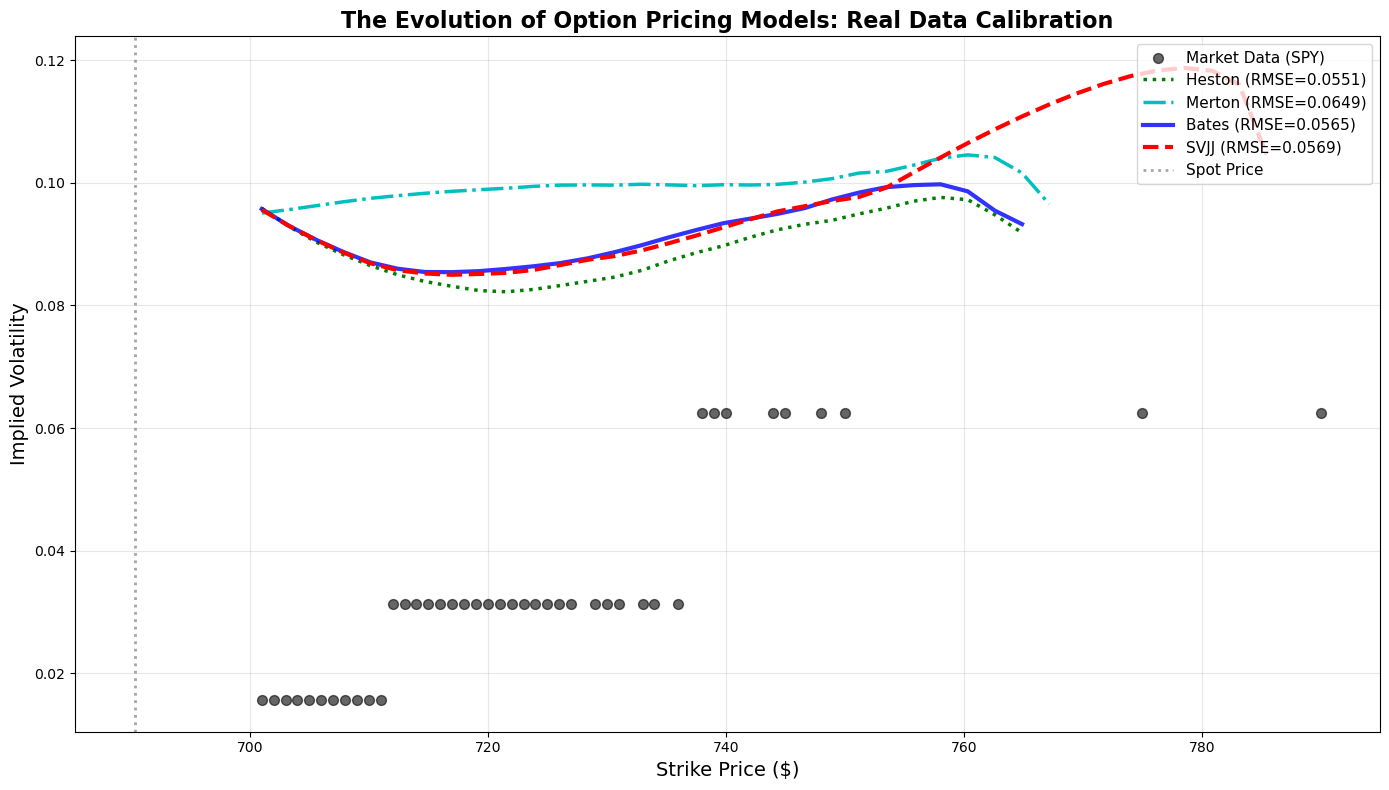

In [15]:
# =============================================================================
# Plot Results
# =============================================================================
plt.figure(figsize=(14, 8))

# Market data
plt.scatter(market_data['strike'], market_data['impliedVolatility'], 
            c='black', s=50, alpha=0.6, label='Market Data (SPY)', zorder=5)

# Model curves
plt.plot(strikes_plot, iv_heston, 'g:', linewidth=2.5, 
         label=f'Heston (RMSE={res_heston.fun:.4f})')
plt.plot(strikes_plot, iv_merton, 'c-.', linewidth=2.5, 
         label=f'Merton (RMSE={res_merton.fun:.4f})')
plt.plot(strikes_plot, iv_bates, 'b-', linewidth=3, alpha=0.8, 
         label=f'Bates (RMSE={res_bates.fun:.4f})')
plt.plot(strikes_plot, iv_svjj, 'r--', linewidth=3, 
         label=f'SVJJ (RMSE={res_svjj.fun:.4f})')

# Spot price line
plt.axvline(current_price, color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Spot Price')

# Labels and styling
plt.xlabel('Strike Price ($)', fontsize=14)
plt.ylabel('Implied Volatility', fontsize=14)
plt.title('The Evolution of Option Pricing Models: Real Data Calibration', fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

## 6. Final Leaderboard

Ranking models by calibration accuracy (lower RMSE = better fit to market data).

In [16]:
# =============================================================================
# Final Leaderboard
# =============================================================================
results = {
    'Heston': res_heston.fun,
    'Merton': res_merton.fun,
    'Bates': res_bates.fun,
    'SVJJ': res_svjj.fun
}

sorted_res = sorted(results.items(), key=lambda x: x[1])

print("\n" + "=" * 50)
print("        🏆 FINAL LEADERBOARD 🏆")
print("=" * 50)

medals = ["🥇", "🥈", "🥉", "  "]
for rank, (name, score) in enumerate(sorted_res):
    print(f"  {medals[rank]} {rank+1}. {name:<10} | RMSE: {score:.5f}")

print("=" * 50)
print(f"\n🎯 Best Model: {sorted_res[0][0]} with RMSE = {sorted_res[0][1]:.5f}")


        🏆 FINAL LEADERBOARD 🏆
  🥇 1. Heston     | RMSE: 0.05514
  🥈 2. Bates      | RMSE: 0.05651
  🥉 3. SVJJ       | RMSE: 0.05695
     4. Merton     | RMSE: 0.06489

🎯 Best Model: Heston with RMSE = 0.05514


---

## Summary

This analysis demonstrates the progression of option pricing models:

1. **Heston**: Captures volatility smile but may miss extreme tails
2. **Merton**: Jump component helps with fat tails but lacks stochastic vol flexibility
3. **Bates**: Combines both, typically performs well
4. **SVJJ**: Most flexible, can capture complex volatility surface dynamics

The "best" model depends on the specific market conditions and the trade-off between accuracy and model complexity.